In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingClassifier

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [57]:
df = pd.read_csv(r"D:\Violet\2022Fall\subway\Amelie\cleaned_chatelet.csv")
df

DATE   NO   NO2   PM10    CO2  TEMP  HUMI  \
0      2014-01-01 01:00:00+00:00  4.0  29.0  101.0  635.0  19.9  46.3   
1      2014-01-01 02:00:00+00:00  4.0  28.0   89.0  738.0  20.0  46.9   
2      2014-01-01 03:00:00+00:00  4.0  28.0   81.0  775.0  20.1  46.5   
3      2014-01-01 04:00:00+00:00  4.0  29.0   71.0  664.0  19.8  45.3   
4      2014-01-01 05:00:00+00:00  4.0  22.0   66.0  560.0  19.6  44.3   
...                          ...  ...   ...    ...    ...   ...   ...   
55971  2022-09-28 21:00:00+00:00  2.0  18.0   36.0  571.0  18.2  43.5   
55972  2022-09-28 22:00:00+00:00  4.0  28.0   39.0  526.0  18.1  46.8   
55973  2022-09-28 23:00:00+00:00  6.0  32.0   36.0  491.0  18.0  49.3   
55974  2022-09-29 00:00:00+00:00  3.0  23.0   11.0  450.0  17.8  50.0   
55975  2022-09-29 01:00:00+00:00  5.0   7.0   20.0  444.0  18.8  47.6   

       WEEK_OF_YEAR  WEEKEND  CO2_BEFORE  ...  HOUR_14  HOUR_15  HOUR_16  \
0                 1        0       776.0  ...        0        0        0   
1                 1        0       800.0  ...        0        0        0   
2                 1        0       799.0  ...        0        0        0   
3                 1        0       715.0  ...        0        0        0   
4                 1        0       622.0  ...        0        0        0   
...             ...      ...         ...  ...      ...      ...      ...   
55971            39        0       550.0  ...        0        0        0   
55972            39        0       490.0  ...        0        0        0   
55973            39        0       474.0  ...        0        0        0   
55974            39        0       451.0  ...        0        0        0   
55975            39        0       443.0  ...        0        0        0   

       HOUR_17  HOUR_18  HOUR_19  HOUR_20  HOUR_21  HOUR_22  HOUR_23  
0            0        0        0        0        0        0        0  
1            0        0        0        0        0        0        0  
2            0        0        0        0        0        0        0  
3            0        0        0        0        0        0        0  
4            0        0        0        0        0        0        0  
...        ...      ...      ...      ...      ...      ...      ...  
55971        0        0        0        0        1        0        0  
55972        0        0        0        0        0        1        0  
55973        0        0        0        0        0        0        1  
55974        0        0        0        0        0        0        0  
55975        0        0        0        0        0        0        0  

[55976 rows x 96 columns]

## DEMO

In [58]:
def construct_features_based_on_past_n_days_data(polution_df,past_n_points):
    feature_df = polution_df.copy(deep=True)
    for i in range(1,past_n_points,1):
        feature_df['past_'+str(i)]=polution_df.shift(i).copy()
    # print(feature_df)
    feature_df.drop(index=feature_df.index[:past_n_points], axis=0, inplace=True)
    return feature_df

In [59]:
df_benchmark_CO2 = df[['CO2_BEFORE']]
df_CO2 = df[['DATE','CO2']]
include_past_n_points=50
df_CO2_time_series = construct_features_based_on_past_n_days_data(df_CO2[['CO2']],include_past_n_points)
df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)
df_benchmark_CO2.drop(index=df_benchmark_CO2.index[:include_past_n_points], axis=0, inplace=True)
# df_CO2_time_series['DATE']=df_CO2["DATE"]



C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\493868323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\493868323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_benchmark_CO2.drop(index=df_benchmark_CO2.index[:include_past_n_points], axis=0, inplace=True)


In [60]:
df_CO2_time_series

CO2  past_1  past_2  past_3  past_4  past_5  past_6  past_7  past_8  \
50     421.0   400.0   404.0   404.0   422.0   502.0   546.0   560.0   616.0   
51     453.0   421.0   400.0   404.0   404.0   422.0   502.0   546.0   560.0   
52     485.0   453.0   421.0   400.0   404.0   404.0   422.0   502.0   546.0   
53     566.0   485.0   453.0   421.0   400.0   404.0   404.0   422.0   502.0   
54     643.0   566.0   485.0   453.0   421.0   400.0   404.0   404.0   422.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
55971  571.0   713.0   757.0   769.0   683.0   623.0   581.0   570.0   564.0   
55972  526.0   571.0   713.0   757.0   769.0   683.0   623.0   581.0   570.0   
55973  491.0   526.0   571.0   713.0   757.0   769.0   683.0   623.0   581.0   
55974  450.0   491.0   526.0   571.0   713.0   757.0   769.0   683.0   623.0   
55975  444.0   450.0   491.0   526.0   571.0   713.0   757.0   769.0   683.0   

       past_9  ...  past_40  past_41  past_42  past_43  past_44  past_45  \
50      690.0  ...    540.0    493.0    466.0    456.0    481.0    512.0   
51      616.0  ...    567.0    540.0    493.0    466.0    456.0    481.0   
52      560.0  ...    600.0    567.0    540.0    493.0    466.0    456.0   
53      546.0  ...    575.0    600.0    567.0    540.0    493.0    466.0   
54      502.0  ...    615.0    575.0    600.0    567.0    540.0    493.0   
...       ...  ...      ...      ...      ...      ...      ...      ...   
55971   538.0  ...    430.0    436.0    470.0    490.0    537.0    616.0   
55972   564.0  ...    423.0    430.0    436.0    470.0    490.0    537.0   
55973   570.0  ...    424.0    423.0    430.0    436.0    470.0    490.0   
55974   581.0  ...    422.0    424.0    423.0    430.0    436.0    470.0   
55975   623.0  ...    431.0    422.0    424.0    423.0    430.0    436.0   

       past_46  past_47  past_48  past_49  
50       560.0    664.0    775.0    738.0  
51       512.0    560.0    664.0    775.0  
52       481.0    512.0    560.0    664.0  
53       456.0    481.0    512.0    560.0  
54       466.0    456.0    481.0    512.0  
...        ...      ...      ...      ...  
55971    739.0    692.0    622.0    612.0  
55972    616.0    739.0    692.0    622.0  
55973    537.0    616.0    739.0    692.0  
55974    490.0    537.0    616.0    739.0  
55975    470.0    490.0    537.0    616.0  

[55926 rows x 50 columns]

In [61]:
y = df_CO2_time_series[['CO2']]
x = df_CO2_time_series.drop(columns=['CO2'])
feature_names = x.columns
x = np.array(x)
y = np.array(y).ravel()

In [62]:
np.shape(y)

(55926,)

In [63]:
test_x = x[-24*3:,:]
train_x = x[-24*100:-24*3,:]
test_y = y[-24*3:]
train_y = y[-24*100:-24*3]

In [64]:
train_y

array([452., 452., 452., ..., 591., 630., 579.])

In [67]:
reg = linear_model.Ridge(alpha=.5)
reg.fit(train_x,train_y)
pred_test_y = reg.predict(test_x)
print("MAE:",mean_absolute_error(test_y,pred_test_y))
print("MAPE:",mean_absolute_percentage_error(test_y,pred_test_y))

MAE: 35.508327883144005
MAPE: 0.06266934918905274


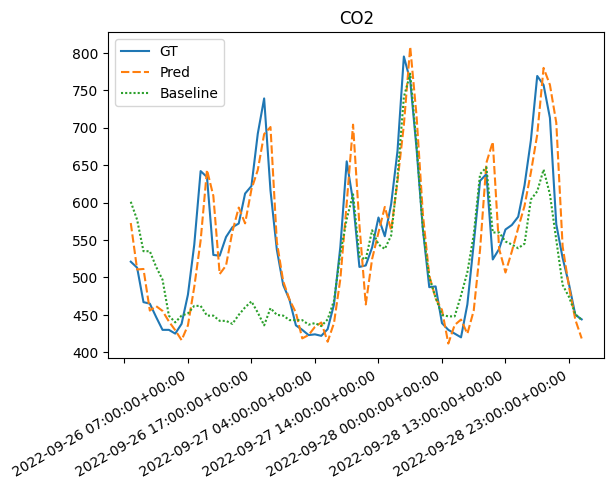

In [68]:
import matplotlib.dates as mdates
test_compare_df = pd.DataFrame({"GT":test_y,"Pred":pred_test_y,'Baseline':np.array(df_benchmark_CO2["CO2_BEFORE"])[-24*3:]},index=np.array(df_CO2["DATE"])[-24*3:])
fig, ax = plt.subplots(figsize=[6.4, 4.8])
chart=sns.lineplot(data=test_compare_df)
fig.autofmt_xdate()
plt.title("CO2")
plt.legend()
# plt.axvline(x=np.array(df_CO2["DATE"])[-24*3], c='r', linestyle='--')
locator = mdates.DayLocator(interval=10)
chart.xaxis.set_major_locator(locator)
plt.show()

## To predict future 24 points(1 day) based on past 99X24 (99 days) data

In [12]:
# df_benchmark_CO2 = df[['CO2_BEFORE']]
df_CO2 = df[['DATE','CO2']]
include_past_n_points=24*100
df_CO2_time_series = construct_features_based_on_past_n_days_data(df_CO2[['CO2']],include_past_n_points)
df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)
# df_benchmark_CO2.drop(index=df_benchmark_CO2.index[:include_past_n_points], axis=0, inplace=True)
# df_CO2_time_series['DATE']=df_CO2["DATE"]

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [13]:
predict_length = 24
df_benchmark_CO2 = df_CO2_time_series[['past_24']]
test_24_points=[]
train_24_points=[]
for i in range(24):
    i = 23-i
    if i ==0:
        y = df_CO2_time_series[['CO2']]
    else:
        y = df_CO2_time_series[['past_'+str(i)]]
    x = df_CO2_time_series.drop(columns=['CO2'])
    for j in range(i):
        x = df_CO2_time_series.drop(columns=['past_'+str(j+1)])
    feature_names = x.columns
    x = np.array(x)
    y = np.array(y).ravel()
    test_x = x[-24:,:]
    train_x = x[-24*100:-24,:]
    test_y = y[-24*3:]
    train_y = y[-24*100:-24]
    reg = linear_model.Ridge(alpha=.5)
    reg.fit(train_x,train_y)
    pred_test_x = reg.predict(train_x)
    pred_test_y = reg.predict(test_x)
    test_24_points.append(pred_test_y[0])
    train_24_points.append(pred_test_x[-1])
print(mean_absolute_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:]))
print(mean_absolute_percentage_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:]))

322.07310551643263
2.8773379034589923


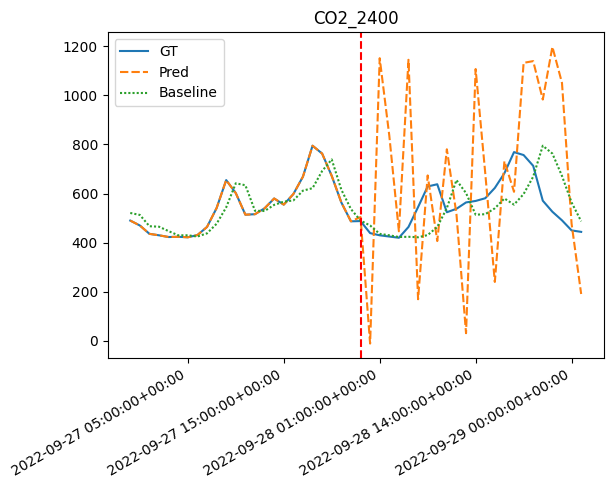

In [14]:
if len(train_24_points)==24:
    train_24_points.extend(test_24_points)
test_compare_df = pd.DataFrame({"GT":np.array(df_CO2_time_series[['CO2']])[-48:].ravel(),"Pred":train_24_points,'Baseline':np.array(df_benchmark_CO2["past_24"])[-48:]},index=np.array(df_CO2["DATE"])[-48:])
fig, ax = plt.subplots(figsize=[6.4, 4.8])
chart=sns.lineplot(data=test_compare_df)
fig.autofmt_xdate()
plt.title("CO2_2400")
plt.legend()
plt.axvline(x=np.array(df_CO2["DATE"])[-24], c='r', linestyle='--')
locator = mdates.DayLocator(interval=10)
chart.xaxis.set_major_locator(locator)
plt.show()

## Training window exploration

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\3831497317.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)


(55951, 1)
(55951, 2)
(55951, 3)
(55951, 4)
(55951, 5)
(55951, 6)
(55951, 7)
(55951, 8)
(55951, 9)
(55951, 10)
(55951, 11)
(55951, 12)
(55951, 13)
(55951, 14)
(55951, 15)
(55951, 16)
(55951, 17)
(55951, 18)
(55951, 19)
(55951, 20)
(55951, 21)
(55951, 22)
(55951, 23)
(55951, 24)


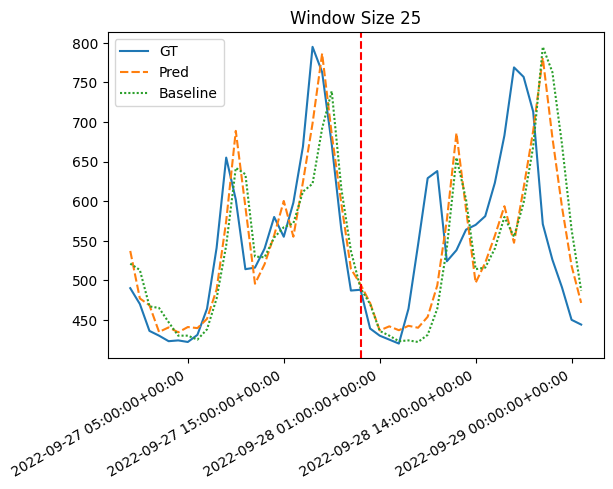

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\3831497317.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)


(55928, 24)
(55928, 25)
(55928, 26)
(55928, 27)
(55928, 28)
(55928, 29)
(55928, 30)
(55928, 31)
(55928, 32)
(55928, 33)
(55928, 34)
(55928, 35)
(55928, 36)
(55928, 37)
(55928, 38)
(55928, 39)
(55928, 40)
(55928, 41)
(55928, 42)
(55928, 43)
(55928, 44)
(55928, 45)
(55928, 46)
(55928, 47)


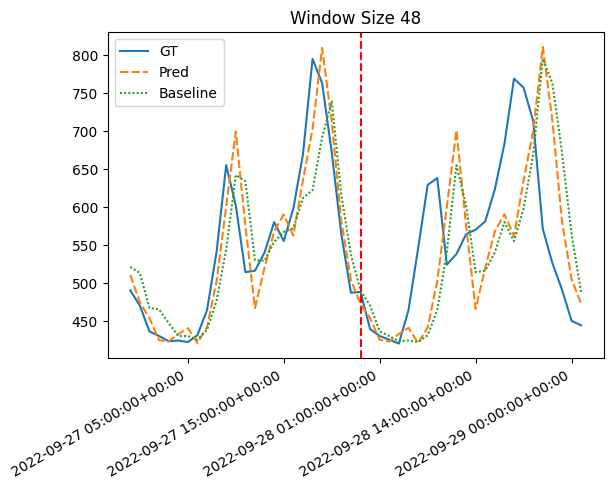

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\3831497317.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)


(55904, 48)
(55904, 49)
(55904, 50)
(55904, 51)
(55904, 52)
(55904, 53)
(55904, 54)
(55904, 55)
(55904, 56)
(55904, 57)
(55904, 58)
(55904, 59)
(55904, 60)
(55904, 61)
(55904, 62)
(55904, 63)
(55904, 64)
(55904, 65)
(55904, 66)
(55904, 67)
(55904, 68)
(55904, 69)
(55904, 70)
(55904, 71)


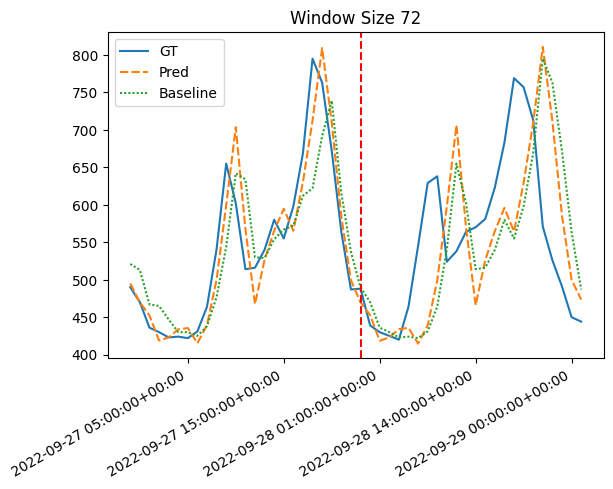

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\3831497317.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)


(55880, 72)
(55880, 73)
(55880, 74)
(55880, 75)
(55880, 76)
(55880, 77)
(55880, 78)
(55880, 79)
(55880, 80)
(55880, 81)
(55880, 82)
(55880, 83)
(55880, 84)
(55880, 85)
(55880, 86)
(55880, 87)
(55880, 88)
(55880, 89)
(55880, 90)
(55880, 91)
(55880, 92)
(55880, 93)
(55880, 94)
(55880, 95)


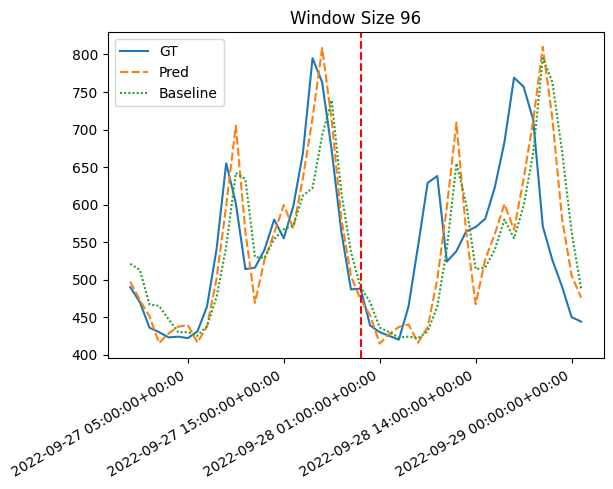

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

(55856, 96)
(55856, 97)
(55856, 98)
(55856, 99)
(55856, 100)
(55856, 101)
(55856, 102)
(55856, 103)
(55856, 104)
(55856, 105)
(55856, 106)
(55856, 107)
(55856, 108)
(55856, 109)
(55856, 110)
(55856, 111)
(55856, 112)
(55856, 113)
(55856, 114)
(55856, 115)
(55856, 116)
(55856, 117)
(55856, 118)
(55856, 119)


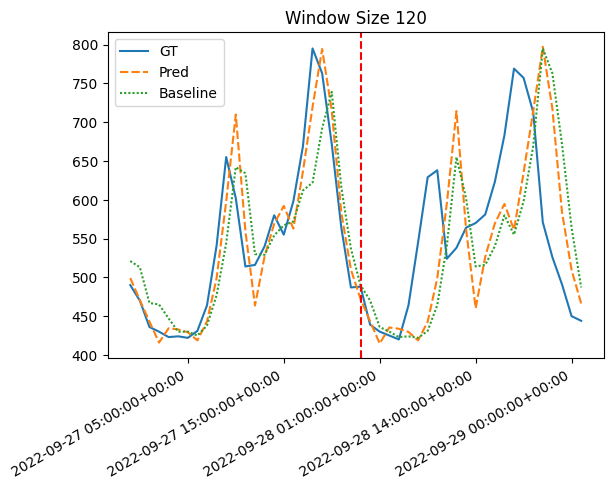

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

(55832, 120)
(55832, 121)
(55832, 122)
(55832, 123)
(55832, 124)
(55832, 125)
(55832, 126)
(55832, 127)
(55832, 128)
(55832, 129)
(55832, 130)
(55832, 131)
(55832, 132)
(55832, 133)
(55832, 134)
(55832, 135)
(55832, 136)
(55832, 137)
(55832, 138)
(55832, 139)
(55832, 140)
(55832, 141)
(55832, 142)
(55832, 143)


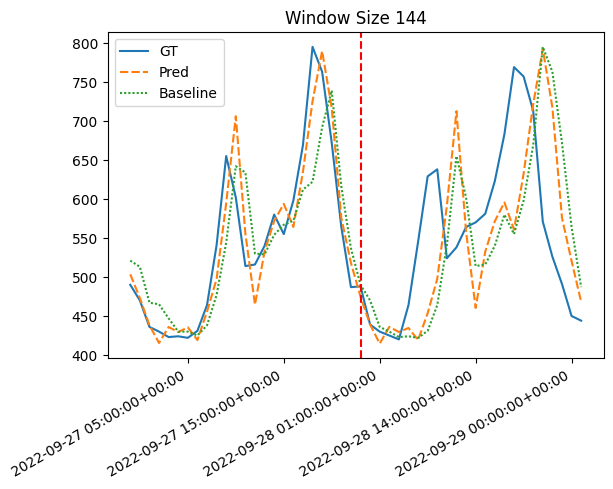

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

(55808, 144)
(55808, 145)
(55808, 146)
(55808, 147)
(55808, 148)
(55808, 149)
(55808, 150)
(55808, 151)
(55808, 152)
(55808, 153)
(55808, 154)
(55808, 155)
(55808, 156)
(55808, 157)
(55808, 158)
(55808, 159)
(55808, 160)
(55808, 161)
(55808, 162)
(55808, 163)
(55808, 164)
(55808, 165)
(55808, 166)
(55808, 167)


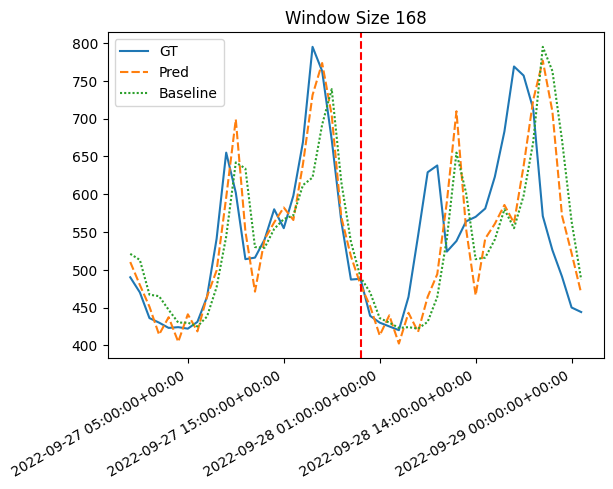

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

(55736, 216)
(55736, 217)
(55736, 218)
(55736, 219)
(55736, 220)
(55736, 221)
(55736, 222)
(55736, 223)
(55736, 224)
(55736, 225)
(55736, 226)
(55736, 227)
(55736, 228)
(55736, 229)
(55736, 230)
(55736, 231)
(55736, 232)
(55736, 233)
(55736, 234)
(55736, 235)
(55736, 236)
(55736, 237)
(55736, 238)
(55736, 239)


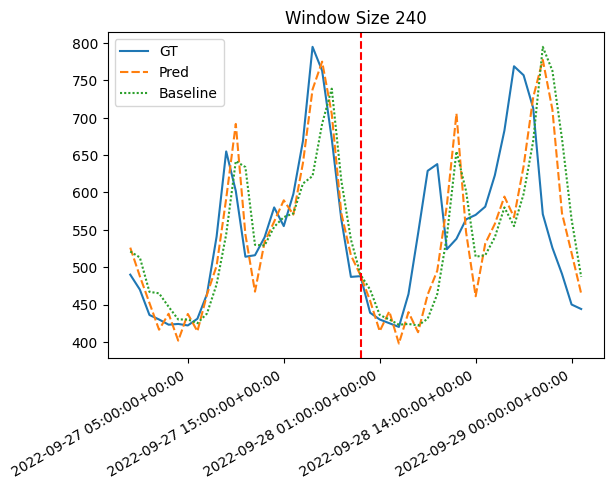

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

(55256, 696)
(55256, 697)
(55256, 698)
(55256, 699)
(55256, 700)
(55256, 701)
(55256, 702)
(55256, 703)
(55256, 704)
(55256, 705)
(55256, 706)
(55256, 707)
(55256, 708)
(55256, 709)
(55256, 710)
(55256, 711)
(55256, 712)
(55256, 713)
(55256, 714)
(55256, 715)
(55256, 716)
(55256, 717)
(55256, 718)
(55256, 719)


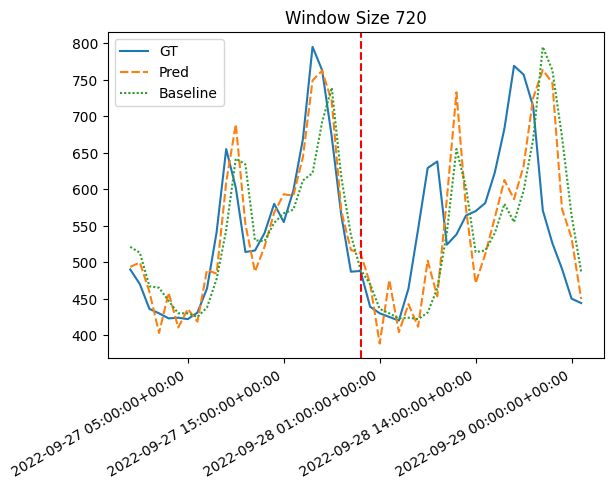

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

(54536, 1416)
(54536, 1417)
(54536, 1418)
(54536, 1419)
(54536, 1420)
(54536, 1421)
(54536, 1422)
(54536, 1423)
(54536, 1424)
(54536, 1425)
(54536, 1426)
(54536, 1427)
(54536, 1428)
(54536, 1429)
(54536, 1430)
(54536, 1431)
(54536, 1432)
(54536, 1433)
(54536, 1434)
(54536, 1435)
(54536, 1436)
(54536, 1437)
(54536, 1438)
(54536, 1439)


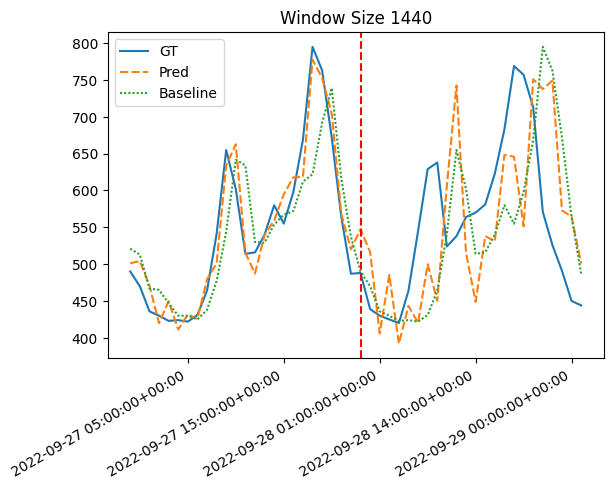

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

(53576, 2376)
(53576, 2377)
(53576, 2378)
(53576, 2379)
(53576, 2380)
(53576, 2381)
(53576, 2382)
(53576, 2383)
(53576, 2384)
(53576, 2385)
(53576, 2386)
(53576, 2387)
(53576, 2388)
(53576, 2389)
(53576, 2390)
(53576, 2391)
(53576, 2392)
(53576, 2393)
(53576, 2394)
(53576, 2395)
(53576, 2396)
(53576, 2397)
(53576, 2398)
(53576, 2399)


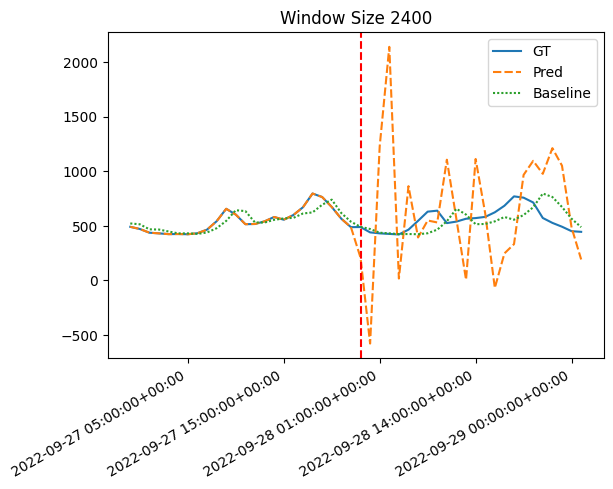

In [28]:
MAEs = []
MAPEs= []
for window_size in [25,24*2,24*3,24*4,24*5,24*6,24*7,24*10,24*30,24*60,24*100]:
    # df_benchmark_CO2 = df[['CO2_BEFORE']]
    df_CO2 = df[['DATE','CO2']]
    include_past_n_points=window_size
    df_CO2_time_series = construct_features_based_on_past_n_days_data(df_CO2[['CO2']],include_past_n_points)
    df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)
    # df_benchmark_CO2.drop(index=df_benchmark_CO2.index[:include_past_n_points], axis=0, inplace=True)
    # df_CO2_time_series['DATE']=df_CO2["DATE"]
    predict_length = 24
    df_benchmark_CO2 = df_CO2_time_series[['past_24']]
    test_24_points=[]
    train_24_points=[]
    for i in range(24):
        i = 23-i
        if i ==0:
            y = df_CO2_time_series[['CO2']]
        else:
            y = df_CO2_time_series[['past_'+str(i)]]
        x = df_CO2_time_series.drop(columns=['CO2'])
        for j in range(i):
            x = x.drop(columns=['past_'+str(j+1)])
        feature_names = x.columns
        x = np.array(x)
        print(np.shape(x))
        y = np.array(y).ravel()
        test_x = x[-24:,:]
        train_x = x[-24*100:-24,:]
        test_y = y[-24*3:]
        train_y = y[-24*100:-24]
        reg = linear_model.Ridge(alpha=.5)
        reg.fit(train_x,train_y)
        pred_test_x = reg.predict(train_x)
        pred_test_y = reg.predict(test_x)
        test_24_points.append(pred_test_y[0])
        train_24_points.append(pred_test_x[-1])
    MAEs.append(mean_absolute_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:]))
    MAPEs.append(mean_absolute_percentage_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:]))
    if len(train_24_points)==24:
        train_24_points.extend(test_24_points)
    test_compare_df = pd.DataFrame({"GT":np.array(df_CO2_time_series[['CO2']])[-48:].ravel(),"Pred":train_24_points,'Baseline':np.array(df_benchmark_CO2["past_24"])[-48:]},index=np.array(df_CO2["DATE"])[-48:])
    fig, ax = plt.subplots(figsize=[6.4, 4.8])
    chart=sns.lineplot(data=test_compare_df)
    fig.autofmt_xdate()
    plt.title("Window Size "+str(window_size))
    plt.legend()
    plt.axvline(x=np.array(df_CO2["DATE"])[-24], c='r', linestyle='--')
    locator = mdates.DayLocator(interval=10)
    chart.xaxis.set_major_locator(locator)
    plt.show()

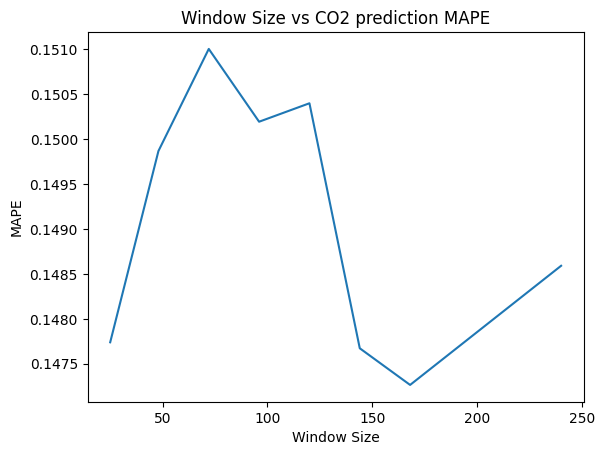

In [36]:
plt.figure()
# plt.plot([24,24*7,24*30,24*50],MAEs)
plt.plot([25,24*2,24*3,24*4,24*5,24*6,24*7,24*10],MAPEs[:-3])#
plt.xlabel("Window Size")
plt.ylabel("MAPE")
plt.title("Window Size vs CO2 prediction MAPE")
plt.show()

## Training set exploration

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

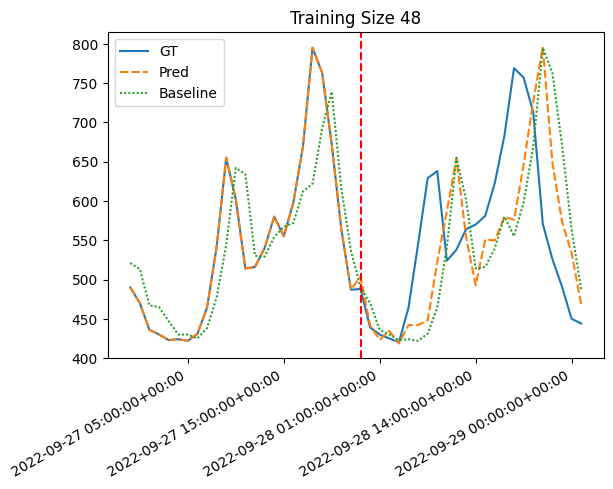

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

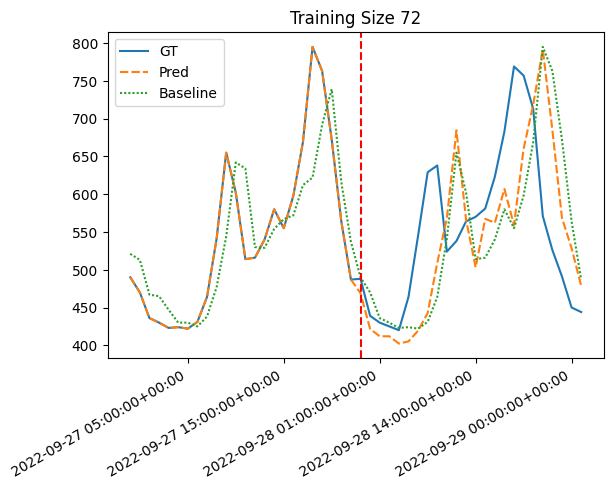

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

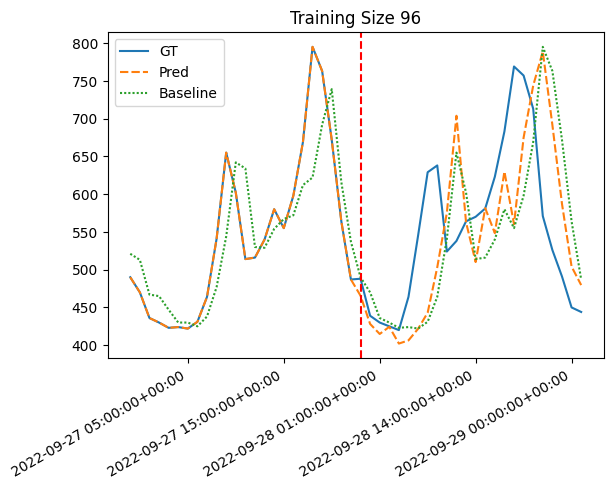

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

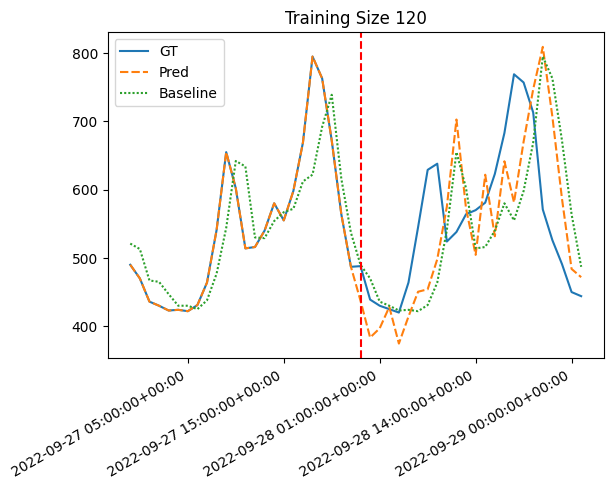

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

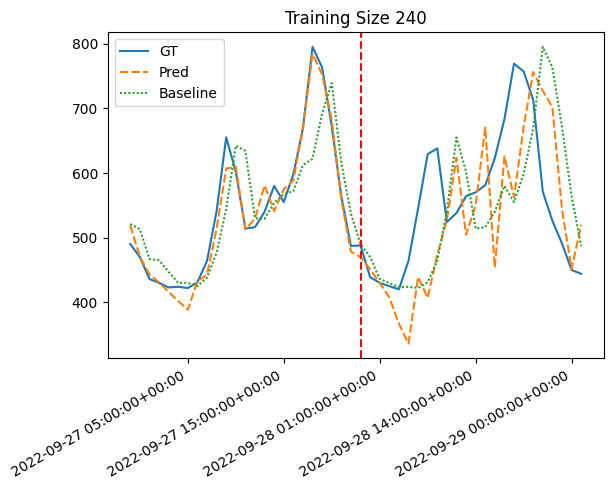

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

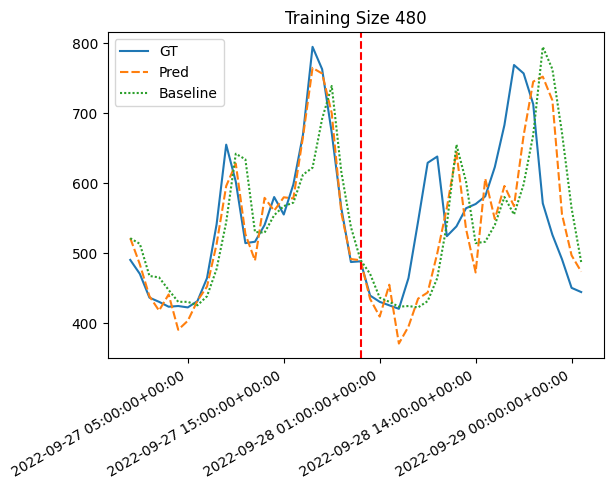

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

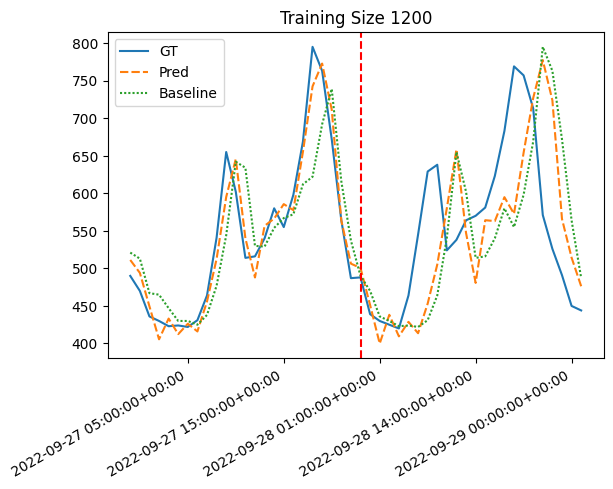

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

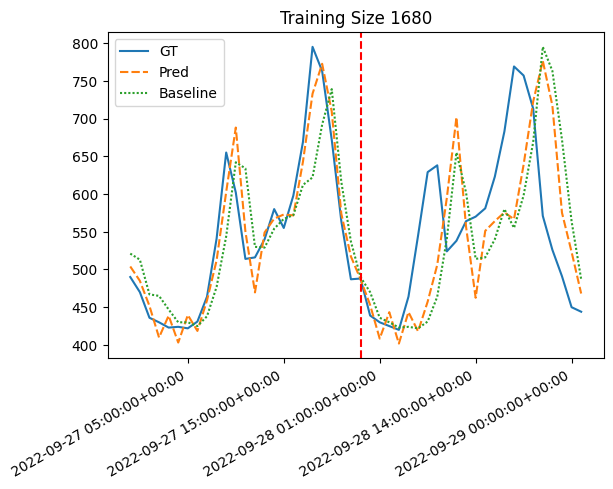

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

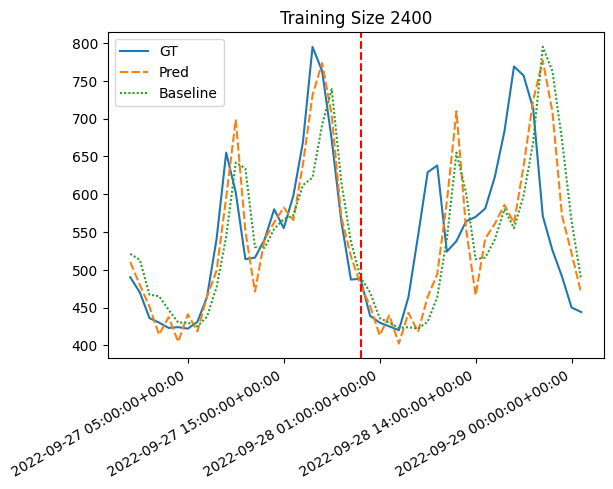

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

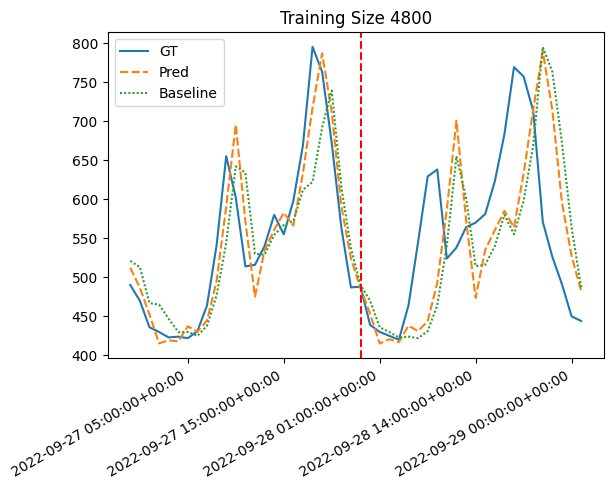

In [41]:
MAEs = []
MAPEs= []
for train_set_size in [24*2,24*3,24*4,24*5,24*10,24*20,24*50,24*70,24*100,24*200]:
    window_size = 24*7
    # df_benchmark_CO2 = df[['CO2_BEFORE']]
    df_CO2 = df[['DATE','CO2']]
    include_past_n_points=window_size
    df_CO2_time_series = construct_features_based_on_past_n_days_data(df_CO2[['CO2']],include_past_n_points)
    df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)
    # df_benchmark_CO2.drop(index=df_benchmark_CO2.index[:include_past_n_points], axis=0, inplace=True)
    # df_CO2_time_series['DATE']=df_CO2["DATE"]
    predict_length = 24
    df_benchmark_CO2 = df_CO2_time_series[['past_24']]
    test_24_points=[]
    train_24_points=[]
    for i in range(24):
        i = 23-i
        if i ==0:
            y = df_CO2_time_series[['CO2']]
        else:
            y = df_CO2_time_series[['past_'+str(i)]]
        x = df_CO2_time_series.drop(columns=['CO2'])
        for j in range(i):
            x = x.drop(columns=['past_'+str(j+1)])
        feature_names = x.columns
        x = np.array(x)
        # print(np.shape(x))
        y = np.array(y).ravel()
        test_x = x[-24:,:]
        train_x = x[-train_set_size:-24,:]
        test_y = y[-24*3:]
        train_y = y[-train_set_size:-24]
        reg = linear_model.Ridge(alpha=.5)
        reg.fit(train_x,train_y)
        pred_test_x = reg.predict(train_x)
        pred_test_y = reg.predict(test_x)
        test_24_points.append(pred_test_y[0])
        train_24_points.append(pred_test_x[-1])
    MAEs.append(mean_absolute_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:]))
    MAPEs.append(mean_absolute_percentage_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:]))
    if len(train_24_points)==24:
        train_24_points.extend(test_24_points)
    test_compare_df = pd.DataFrame({"GT":np.array(df_CO2_time_series[['CO2']])[-48:].ravel(),"Pred":train_24_points,'Baseline':np.array(df_benchmark_CO2["past_24"])[-48:]},index=np.array(df_CO2["DATE"])[-48:])
    fig, ax = plt.subplots(figsize=[6.4, 4.8])
    chart=sns.lineplot(data=test_compare_df)
    fig.autofmt_xdate()
    plt.title("Training Size "+str(train_set_size))
    plt.legend()
    plt.axvline(x=np.array(df_CO2["DATE"])[-24], c='r', linestyle='--')
    locator = mdates.DayLocator(interval=10)
    chart.xaxis.set_major_locator(locator)
    plt.show()

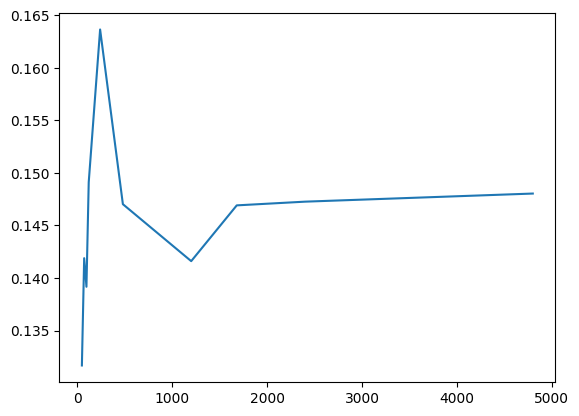

In [42]:
plt.figure()
# plt.plot([24,24*7,24*30,24*50],MAEs)
plt.plot([24*2,24*3,24*4,24*5,24*10,24*20,24*50,24*70,24*100,24*200],MAPEs)#
plt.show()

## Look at correlation

In [43]:
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 640x480 with 0 Axes>

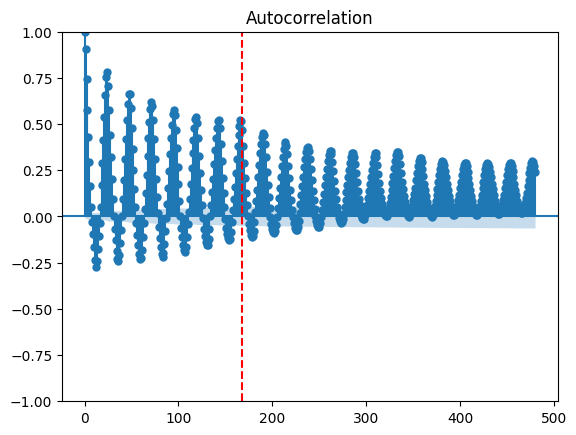

In [55]:
df_CO2 = df[['CO2']]
plt.figure()
plot_acf(df_CO2,lags=24*20)
plt.axvline(x=24*7, c='r', linestyle='--')
plt.show()

<Figure size 640x480 with 0 Axes>

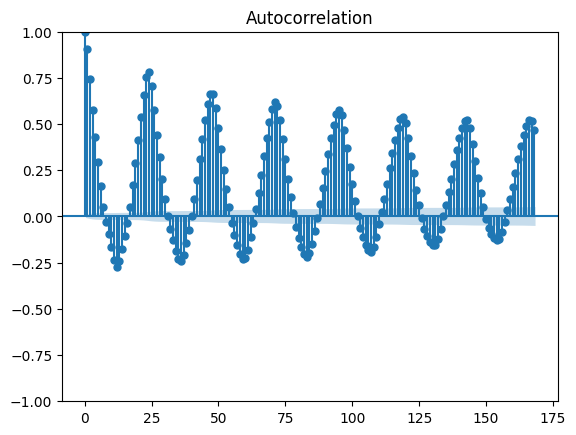

In [56]:
plt.figure()
plot_acf(df_CO2,lags=24*7)
plt.show()

## Final Model for future day prediction

C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df['past_'+str(i)]=polution_df.shift(i).copy()
C:\Users\Qing\AppData\Local\Temp\ipykernel_21860\1408909749.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

MAE: 78.77507886920688
MAPE: 0.14160433662484664
Baseline MAE: 94.875
Baseline MAPE: 0.16797891537645915


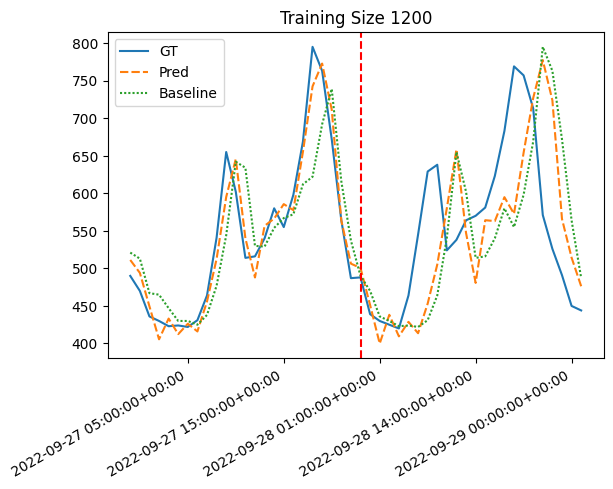

In [69]:

train_set_size = 24*50
window_size = 24*7
# df_benchmark_CO2 = df[['CO2_BEFORE']]
df_CO2 = df[['DATE','CO2']]
include_past_n_points=window_size
df_CO2_time_series = construct_features_based_on_past_n_days_data(df_CO2[['CO2']],include_past_n_points)
df_CO2.drop(index=df_CO2.index[:include_past_n_points], axis=0, inplace=True)
# df_benchmark_CO2.drop(index=df_benchmark_CO2.index[:include_past_n_points], axis=0, inplace=True)
# df_CO2_time_series['DATE']=df_CO2["DATE"]
predict_length = 24
df_benchmark_CO2 = df_CO2_time_series[['past_24']]
test_24_points=[]
train_24_points=[]
for i in range(24):
    i = 23-i
    if i ==0:
        y = df_CO2_time_series[['CO2']]
    else:
        y = df_CO2_time_series[['past_'+str(i)]]
    x = df_CO2_time_series.drop(columns=['CO2'])
    for j in range(i):
        x = x.drop(columns=['past_'+str(j+1)])
    feature_names = x.columns
    x = np.array(x)
    # print(np.shape(x))
    y = np.array(y).ravel()
    test_x = x[-24:,:]
    train_x = x[-train_set_size:-24,:]
    test_y = y[-24*3:]
    train_y = y[-train_set_size:-24]
    reg = linear_model.Ridge(alpha=.5)
    reg.fit(train_x,train_y)
    pred_test_x = reg.predict(train_x)
    pred_test_y = reg.predict(test_x)
    test_24_points.append(pred_test_y[0])
    train_24_points.append(pred_test_x[-1])
print("MAE:",(mean_absolute_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:])))
print("MAPE:",(mean_absolute_percentage_error(test_24_points,np.array(df_CO2_time_series[['CO2']])[-24:])))
print("Baseline MAE:",(mean_absolute_error(np.array(df_benchmark_CO2["past_24"])[-24:],np.array(df_CO2_time_series[['CO2']])[-24:])))
print("Baseline MAPE:",(mean_absolute_percentage_error(np.array(df_benchmark_CO2["past_24"])[-24:],np.array(df_CO2_time_series[['CO2']])[-24:])))
if len(train_24_points)==24:
    train_24_points.extend(test_24_points)
test_compare_df = pd.DataFrame({"GT":np.array(df_CO2_time_series[['CO2']])[-48:].ravel(),"Pred":train_24_points,'Baseline':np.array(df_benchmark_CO2["past_24"])[-48:]},index=np.array(df_CO2["DATE"])[-48:])
fig, ax = plt.subplots(figsize=[6.4, 4.8])
chart=sns.lineplot(data=test_compare_df)
fig.autofmt_xdate()
plt.title("Training Size "+str(train_set_size))
plt.legend()
plt.axvline(x=np.array(df_CO2["DATE"])[-24], c='r', linestyle='--')
locator = mdates.DayLocator(interval=10)
chart.xaxis.set_major_locator(locator)
plt.show()